In [ ]:
!unzip "Roboticsobjects.v2-sign_language_dataset.folder.zip" -d dataset

Archive:  Roboticsobjects.v2-sign_language_dataset.folder.zip
  inflating: dataset/README.dataset.txt  
  inflating: dataset/README.roboflow.txt  
   creating: dataset/test/
   creating: dataset/test/Go/
 extracting: dataset/test/Go/IMG_0274_jpg.rf.694aeab2be850507d6301c574ccb1ba6.jpg  
 extracting: dataset/test/Go/IMG_0303_jpg.rf.3f435026cfe6bc11ccc407367dcd995c.jpg  
 extracting: dataset/test/Go/IMG_0335_jpg.rf.8b7cfdba2b3bcda6666e9afd5d6d9fc1.jpg  
 extracting: dataset/test/Go/IMG_0343_jpg.rf.44a3382c443efb07d2b8e1058d990e02.jpg  
 extracting: dataset/test/Go/IMG_0355_jpg.rf.2ff0a59ba649723eab8ab7566a2a29b8.jpg  
 extracting: dataset/test/Go/IMG_0371_jpg.rf.aa6de5604921cf4168d6ff6da8da6fcc.jpg  
 extracting: dataset/test/Go/IMG_0445_jpg.rf.c3c13b30c62ac1574774c3e0b72ca546.jpg  
 extracting: dataset/test/Go/IMG_0461_jpg.rf.51899b43077a049ede24ecff4496a1c1.jpg  
 extracting: dataset/test/Go/IMG_0469_jpg.rf.d653d0b033d0688068142fa68d28c474.jpg  
 extracting: dataset/test/Go/IMG_0499_jp

In [ ]:
!ls dataset

README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
!pip install mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 10.6 MB/s eta 0:00:0

In [ ]:
import mediapipe as mp
import cv2
import numpy as np
import os
import pandas as pd

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.1,
    min_tracking_confidence=0.1,
    model_complexity=1
)

def normalize_landmarks(landmarks):
    # landmarks = list of (x,y)
    lm = np.array(landmarks)

    # 1. Wrist as origin
    wrist = lm[0]
    lm = lm - wrist

    # 2. Scale normalize (divide by max distance)
    max_dist = np.max(np.sqrt(np.sum(lm**2, axis=1)))
    lm = lm / max_dist

    return lm.flatten()  # convert 21x2 → 42D vector

def compute_finger_spreads(lm):
    """
    Compute distances between adjacent finger bases (MCPs)
    This helps distinguish "Go" (fingers spread) from "Stop" (fingers together)

    lm: normalized landmarks as 21x2 array
    Returns: 3 spread distances
    """
    idx_mcp = lm[5]   # index finger MCP
    mid_mcp = lm[9]   # middle finger MCP
    rng_mcp = lm[13]  # ring finger MCP
    pnk_mcp = lm[17]  # pinky finger MCP

    spread_idx_mid = np.linalg.norm(idx_mcp - mid_mcp)
    spread_mid_rng = np.linalg.norm(mid_mcp - rng_mcp)
    spread_rng_pnk = np.linalg.norm(rng_mcp - pnk_mcp)

    return np.array([spread_idx_mid, spread_mid_rng, spread_rng_pnk])

dataset = []

root_dir = "dataset" # path to unzipped dataset
splits = ["train", "valid", "test"]

total_images = 0
processed_images = 0

for split in splits:
    split_path = os.path.join(root_dir, split)
    classes = sorted(os.listdir(split_path))

    for cls in classes:
        class_path = os.path.join(split_path, cls)

        for filename in os.listdir(class_path):
            if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            total_images += 1
            img_path = os.path.join(class_path, filename)

            img = cv2.imread(img_path)
            if img is None:
                print("Failed to load:", img_path)
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = hands.process(img_rgb)

            if not result.multi_hand_landmarks:
                print("No hand detected:", img_path)
                continue

            hand = result.multi_hand_landmarks[0]
            landmarks = [(lm.x, lm.y) for lm in hand.landmark]

            # Normalize landmarks (42 features)
            landmarks_norm = normalize_landmarks(landmarks)

            # Compute finger spreads (3 features)
            lm_2d = landmarks_norm.reshape(21, 2)
            spreads = compute_finger_spreads(lm_2d)

            # Combine: 42 normalized landmarks + 3 finger spreads = 45 features
            processed_images += 1
            row = [filename, cls, split] + landmarks_norm.tolist() + spreads.tolist()
            dataset.append(row)

hands.close()

print(f"Total images: {total_images}")
print(f"Processed images: {processed_images}")

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


No hand detected: dataset/train/Go/IMG_0523_jpg.rf.ee72d92c1fa6332e10d9cc9017585cee.jpg
No hand detected: dataset/train/Go/IMG_0523_jpg.rf.eb6187b80d46041a717457c71078b702.jpg
No hand detected: dataset/train/Go/IMG_0523_jpg.rf.e031fc0467b19a406a632b2b9c33108c.jpg
No hand detected: dataset/train/Go/IMG_0573_jpg.rf.aee0bbb3bffd85454fee4f25119c7e4e.jpg
No hand detected: dataset/train/Left/IMG_0410_jpg.rf.8fb392726740e5e4b5436b7ff02b305a.jpg
No hand detected: dataset/train/Left/IMG_0702_jpg.rf.5909f120b339464f792c51be7b5229f8.jpg
No hand detected: dataset/train/Left/IMG_0525_jpg.rf.fbaa657f63f5dd774e0962cf75341027.jpg
No hand detected: dataset/train/Left/IMG_0455_jpg.rf.9e77d942ff2cc87693bca7fa9a912db3.jpg
No hand detected: dataset/train/Left/IMG_0414_jpg.rf.1b5e6af0819436915da87585d568dd8b.jpg
No hand detected: dataset/train/Left/photo_2025-11-18_18-09-51_jpg.rf.c0cf7a1b0616517170665ba510c76b77.jpg
No hand detected: dataset/train/Left/IMG_0285_jpg.rf.1e1015a8383f3572dafae05447045a68.jpg
N

In [ ]:
# Create DataFrame
cols = ["file", "label", "split"]
cols += [f"x{i}" for i in range(21)] + [f"y{i}" for i in range(21)]
cols += ["spread_idx_mid", "spread_mid_rng", "spread_rng_pnk"]

df = pd.DataFrame(dataset, columns=cols)

# Save to CSV
df.to_csv("gesture_landmarks_enhanced.csv", index=False)
print("\nSaved to gesture_landmarks_enhanced.csv")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())


Saved to gesture_landmarks_enhanced.csv
Shape: (1381, 48)

First few rows:
                                                file label  split   x0   x1  \
0  IMG_0232_jpg.rf.a03fff0f7ce789261637b6a416c601...    Go  train  0.0  0.0   
1  IMG_0428_jpg.rf.d02f42717686545a04f3439b482a1d...    Go  train  0.0  0.0   
2  IMG_0436_jpg.rf.529d6e5ea02c1f1ed0f258f3477eb1...    Go  train  0.0  0.0   
3  IMG_0481_jpg.rf.695356cb2b2e282bcc0cbb9ecf4eeb...    Go  train  0.0  0.0   
4  IMG_0679_jpg.rf.0d646d53a6371ef266a0752c27218c...    Go  train  0.0  0.0   

         x2        x3        x4        x5        x6  ...       y14       y15  \
0  0.190807 -0.026402  0.348377 -0.115070  0.472057  ... -0.418063 -0.159656   
1  0.163841 -0.113658  0.272408 -0.270651  0.355683  ... -0.359808 -0.368451   
2  0.180654 -0.071737  0.329530 -0.205083  0.441138  ... -0.428242 -0.225464   
3  0.170724 -0.047349  0.300380 -0.139502  0.384209  ... -0.405529 -0.243195   
4  0.151498 -0.103973  0.266512 -0.269790  0.3702

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import pickle

In [ ]:
# Load data
df = pd.read_csv("gesture_landmarks_enhanced.csv")

print(f"Dataset shape: {df.shape}")
print(f"Classes: {df['label'].unique()}")
print(f"Samples per class:\n{df['label'].value_counts()}")

Dataset shape: (1381, 48)
Classes: ['Go' 'Left' 'Right' 'Stop']
Samples per class:
label
Go       374
Left     344
Stop     338
Right    325
Name: count, dtype: int64


In [ ]:
df["split"].value_counts()



,count
split,
train,1206
valid,89
test,86


In [ ]:
# Split data
df_train = df[df["split"] == "train"]
df_valid = df[df["split"] == "valid"]
df_test = df[df["split"] == "test"]

In [ ]:
# Select all features: 42 landmarks + 3 spreads = 45 features
feature_cols = (
    [f"x{i}" for i in range(21)] +
    [f"y{i}" for i in range(21)] +
    ["spread_idx_mid", "spread_mid_rng", "spread_rng_pnk"]
)

X_train = df_train[feature_cols].values
X_valid = df_valid[feature_cols].values
X_test = df_test[feature_cols].values

y_train = df_train["label"].values
y_valid = df_valid["label"].values
y_test = df_test["label"].values

print(f"\nFeature shape: {X_train.shape}")


Feature shape: (1206, 45)


In [ ]:
# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc = le.transform(y_test)

num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_valid_cat = to_categorical(y_valid_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

print(f"Label classes: {le.classes_}")

Label classes: ['Go' 'Left' 'Right' 'Stop']


In [ ]:
# Build model
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,404 (56.27 KB)

 Trainable params: 14,404 (56.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_valid, y_valid_cat),
    epochs=100,
    batch_size=32,
    callbacks=[callback],
    verbose=1
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5455 - loss: 1.1340 - val_accuracy: 0.9551 - val_loss: 0.4194
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8346 - loss: 0.4150 - val_accuracy: 0.9775 - val_loss: 0.2396
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9273 - loss: 0.2309 - val_accuracy: 0.9888 - val_loss: 0.1477
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9817 - loss: 0.1237 - val_accuracy: 0.9775 - val_loss: 0.1045
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9829 - loss: 0.0694 - val_accuracy: 0.9888 - val_loss: 0.0908
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9959 - loss: 0.0346 - val_accuracy: 0.9775 - val_loss: 0.0932
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9950 - loss: 0.0308 - val_accuracy: 0.9775 - val_loss: 0.0938
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0221 - val_accuracy: 0.9775 - 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

TEST SET EVALUATION

Overall Test Accuracy: 1.000 (100.0%)

Classification Report:
              precision    recall  f1-score   support

          Go       1.00      1.00      1.00        21
        Left       1.00      1.00      1.00        16
       Right       1.00      1.00      1.00        20
        Stop       1.00      1.00      1.00        29

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86


Confusion Matrix:
[[21  0  0  0]
 [ 0 16  0  0]
 [ 0  0 20  0]
 [ 0  0  0 29]]


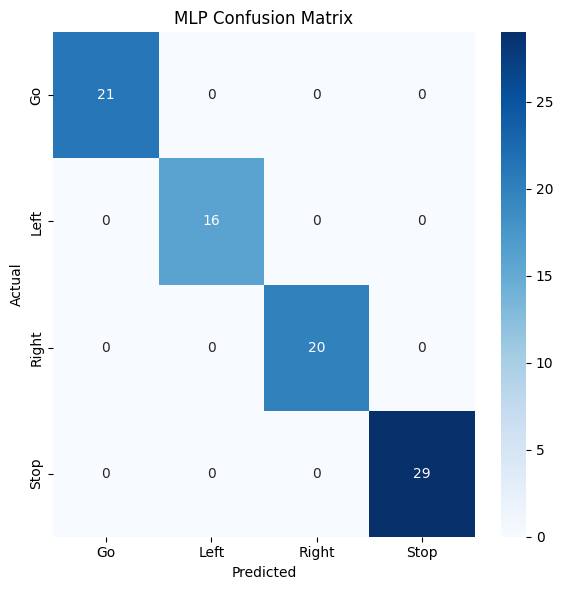

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# Evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)

print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)
print(f"\nOverall Test Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Plot (Seaborn heatmap style)
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[label.split('.')[-1] for label in le.classes_],
    yticklabels=[label.split('.')[-1] for label in le.classes_]
)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
# Save model and label encoder
model.save("gesture_model_v3.h5")
with open("gesture_label_encoder_v3.pkl", "wb") as f:
    pickle.dump(le, f)

print("\n" + "="*50)
print("Model saved as: gesture_model_v3.h5")
print("Label encoder saved as: gesture_label_encoder_v3.pkl")
print("="*50)


Model saved as: gesture_model_v3.h5
Label encoder saved as: gesture_label_encoder_v3.pkl


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("gesture_mlp_model_v3.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpw4zai3o4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 45), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134106476348432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134106476349776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134106476350352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134106476349392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134106476349200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134106476350544: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# !pip install keras2onnx
# !pip install onnx
!pip install tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.

In [ ]:
import tensorflow as tf
import tf2onnx

# Load the trained model
model = tf.keras.models.load_model("gesture_model_v3.h5")

# Number of features = 45 (42 normalized landmarks + 3 finger spreads)
INPUT_SIZE = 45

# Wrap into functional model
inputs = tf.keras.Input(shape=(INPUT_SIZE,), name="input")
outputs = model(inputs)
functional_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="gesture_mlp_model_v3")

print(f"Model input shape: {functional_model.input_shape}")
print(f"Model output shape: {functional_model.output_shape}")

# Convert to ONNX
spec = (tf.TensorSpec((None, INPUT_SIZE), tf.float32, name="input"),)

model_proto, _ = tf2onnx.convert.from_keras(
    functional_model,
    input_signature=spec,
    opset=13
)

# Save file
output_path = "gesture_mlp_model_v3.onnx"
with open(output_path, "wb") as f:
    f.write(model_proto.SerializeToString())

print(f"\nONNX model saved to: {output_path}")
print(f"Input size: {INPUT_SIZE} features")

Model input shape: (None, 45)
Model output shape: (None, 4)

ONNX model saved to: gesture_mlp_model_v3.onnx
Input size: 45 features
